# Сборный проект 1:<br>**«Исследование интернет магазина видеоигр»**

В интернет-магазине «Стримчик» продаются компьютерные игры по всему миру. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Имеются данные до 2016 года. Представим, что сейчас декабрь 2016 г., и необходимо спланировать кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируются продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

**Описание данных:**
- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats as st

In [22]:
COLOR = sns.color_palette('Set2')

## Шаг 1. Загрузка данных

### Загрузка данных

In [3]:
df = pd.read_csv('/datasets/games.csv')

### Изучение данных

In [4]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Вывод

Были получены данные по продажам интернет магазина. В полученных данных есть пропуски, не правильно указан типы данных и указаны не корректные названия столбцов. Ошибки будут обработаны в Шаге 2.

## Шаг 2. Подготовка данных

### Приведение названий столбцов к нижнему регистру

In [6]:
df.columns = df.columns.str.lower()

### Изменение типов данных

`user_score` преобразуем в тип данных `float`, для этого нужно обработать значение `tbd`. Заменим его на `NaN` (тоже тип данных `float`). Tbd означает, что рейтинг для игры еще не определен. Этот показатель не важен в данном иследовании, им можно принебречь.

In [7]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)

In [8]:
df['user_score'] = df['user_score'].astype(float)

### Обработка пропусков

Обработаем пропуски в столбце `year_of_release`:

In [9]:
df['year_of_release'].isna().sum()

269

Данных без даты релиза в районе 1,5%. В данном исследовании они не важны, от них можно избавиться. Это позволит избежать ошибки при преобразовании столбца в тип данных `int`.

In [10]:
df = df.dropna(subset=['year_of_release'])

In [11]:
df['year_of_release'] = df['year_of_release'].astype(int)

Пропуски в столбце `rating` заменим на `not_defined`:

In [12]:
df['rating'] = df['rating'].fillna('not_defined')

In [13]:
df['rating'].unique()

array(['E', 'not_defined', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

### Проверка на дубликаты

Проверим на явные дубликаты:

In [14]:
df.duplicated().sum()

0

Явных дубликатов нет. Проверим на неявные дубликаты:

In [15]:
mask = df[['name', 'platform', 'year_of_release']].duplicated()

In [16]:
mask.sum()

2

Имеем два дубликата.

In [17]:
df[mask]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14244,NaN,GEN,1993,NaN,0.0,0.00,0.03,0.0,NaN,NaN,not_defined
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.00,0.0,83.0,5.5,E


In [18]:
df = df[~ mask]
df = df.reset_index(drop=True)

### Объединение данных по продажам

Для дальнейшего анализа необходимо вынести общие продажи со всех регионов в отдельный столбец.

In [19]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

### Вывод

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.5+ MB


- Названия столбцов датафрейма приведены к `snake_case`;
- Столбец `user_score` преобразован в тип данных `float`, для этого значения `tbd` заменины на `NaN`;
- Пропуски в столбце `year_of_release`, составляющие 1,5% от общей выборки были удалены, так как в данном исследовании они не важны;
- Пропуски в столбце `rating` заполнены значениями `not_defined`;
- Явные дубликаты не обнаружены;
- Обнаружены и удалены два неявных дубликата;
- Остальные пропуски не тронуты.

## Шаг 3. Исследовательский анализ данных

### Количество релизов в разные годы

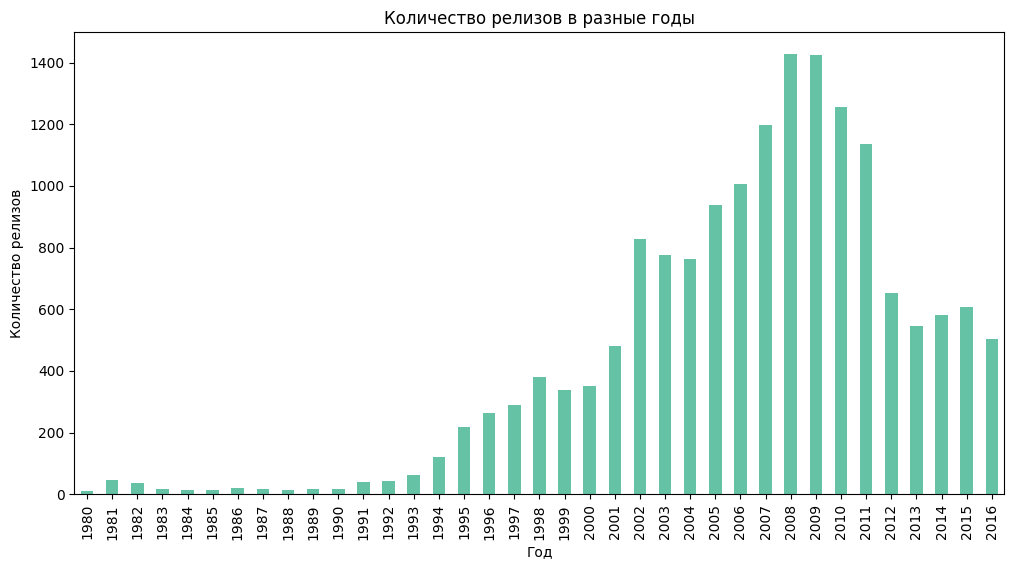

In [23]:
releases_by_year = (
    df.pivot_table(
        index='year_of_release',
        values='platform',
        aggfunc='count')
    .plot(
    kind='bar',
    figsize=(12, 6),
    xlabel='Год',
    ylabel='Количество релизов',
    title = 'Количество релизов в разные годы',
    legend=False,
    color=COLOR
    )
)

В данном иследовании нас интересует современная игровая индустрия, условную границу которой можно обозначить 2000 годом, после этого года и до 2016, вышли 5 самых популярных платформ.

In [24]:
df = df.query('year_of_release > 1999')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14469 entries, 0 to 16443
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             14469 non-null  object 
 1   platform         14469 non-null  object 
 2   year_of_release  14469 non-null  int64  
 3   genre            14469 non-null  object 
 4   na_sales         14469 non-null  float64
 5   eu_sales         14469 non-null  float64
 6   jp_sales         14469 non-null  float64
 7   other_sales      14469 non-null  float64
 8   critic_score     7886 non-null   float64
 9   user_score       7370 non-null   float64
 10  rating           14469 non-null  object 
 11  total_sales      14469 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.4+ MB


### Изменение продаж по платформам за всё время

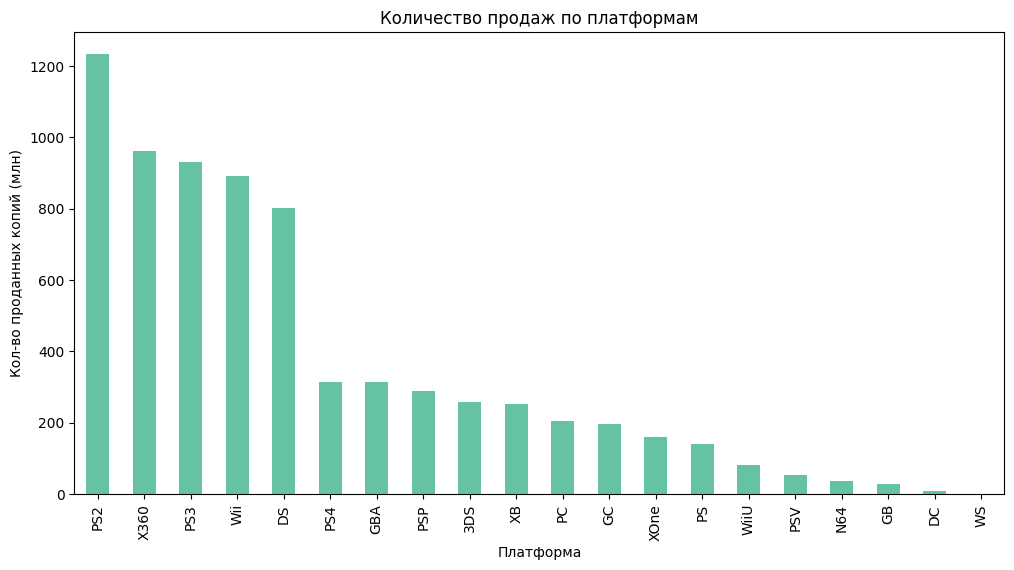

In [26]:
top_sales = (
    df.pivot_table(
        index='platform',
        values='total_sales',
        aggfunc='sum')
    .sort_values(
        by='total_sales',
        ascending=False)
)

top_sales.plot(
    kind='bar',
    figsize=(12, 6),
    xlabel='Платформа',
    ylabel='Кол-во проданных копий (млн)',
    title = 'Количество продаж по платформам',
    legend=False,
    color=COLOR
);

Возьмем ТОП-5 платформ из графика выше и построим распределения продаж по годам:

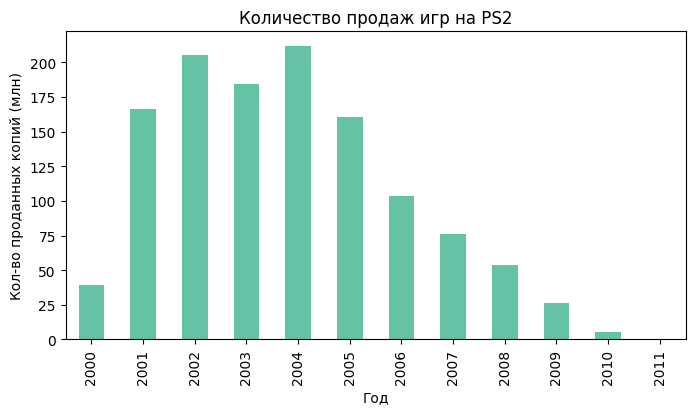

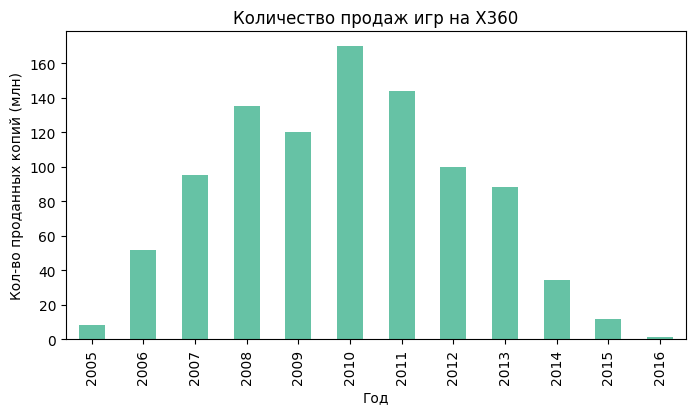

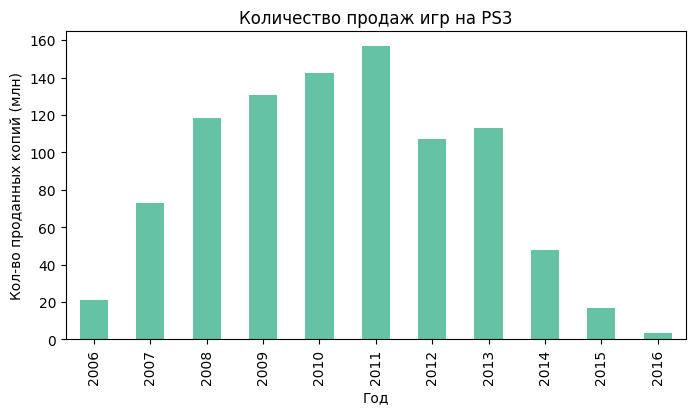

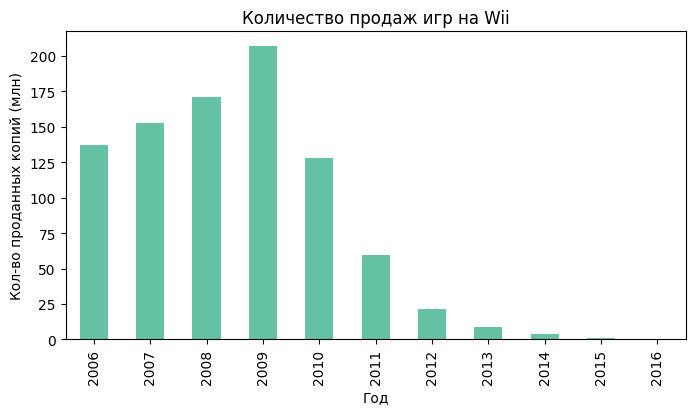

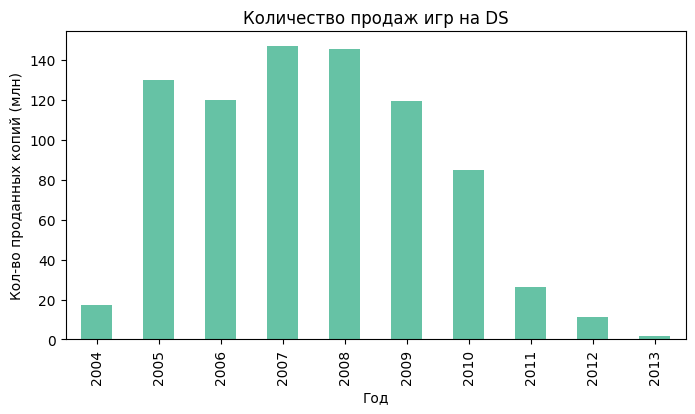

In [27]:
for platform in top_sales.reset_index()['platform'].head():
    res = (
        df.query('platform == @platform')
        .pivot_table(
            index='year_of_release',
            values='total_sales',
            aggfunc='sum')
        .plot(
            kind='bar',
            figsize=(8, 4),
            xlabel='Год',
            ylabel='Кол-во проданных копий (млн)',
            title = f'Количество продаж игр на {platform}',
            legend=False,
            color=COLOR

        )
    )

По распределениям выше можно сделать вывод, что жизненный цикл популярных платформ составляет 7-10 лет, с пиком продаж приблизительно на середине цикла (4-5 лет), тоесть можно сделать вывод, что актуальный период половина жизненного цикла. </p>**Возьмем за атуальный период 5 лет.**

### Изменение продаж по платформам за актуальный период

Выведем график платформ по продажам за актуальный период (с 2012 по 2016 год, включительно):

In [28]:
modern_period_df = df.query('year_of_release > 2011')

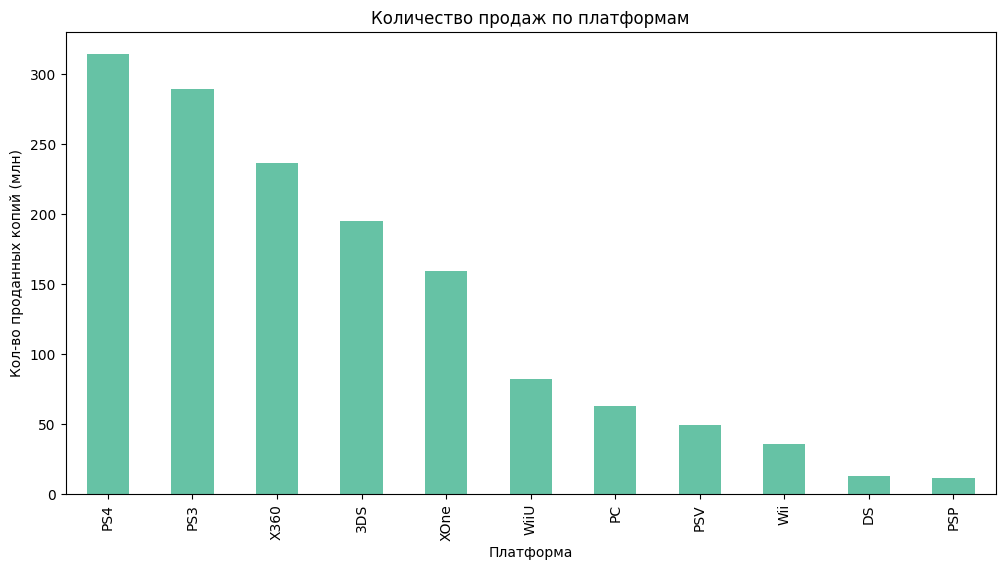

In [30]:
modern_platforms = (
    modern_period_df
    .pivot_table(
        index='platform',
        values='total_sales',
        aggfunc='sum')
    .sort_values(
        by='total_sales',
        ascending=False)
)

modern_platforms.plot(
    kind='bar',
    figsize=(12, 6),
    xlabel='Платформа',
    ylabel='Кол-во проданных копий (млн)',
    title = 'Количество продаж по платформам',
    legend=False,
    color=COLOR
);

Подробно рассмотрим новый ТОП-5 уже за актуальный перод:

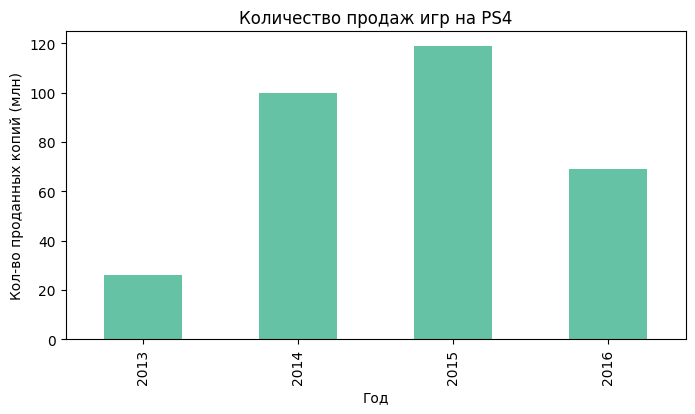

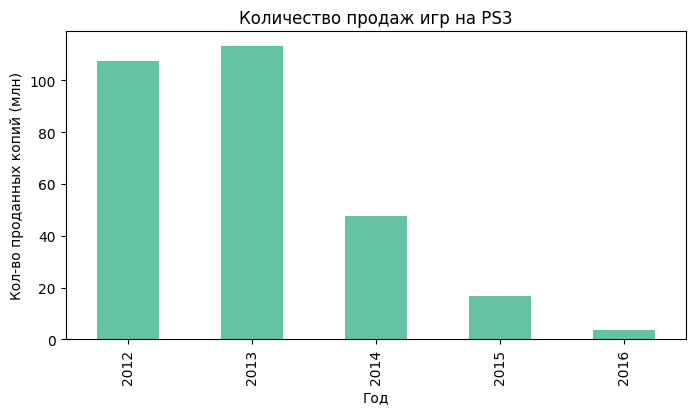

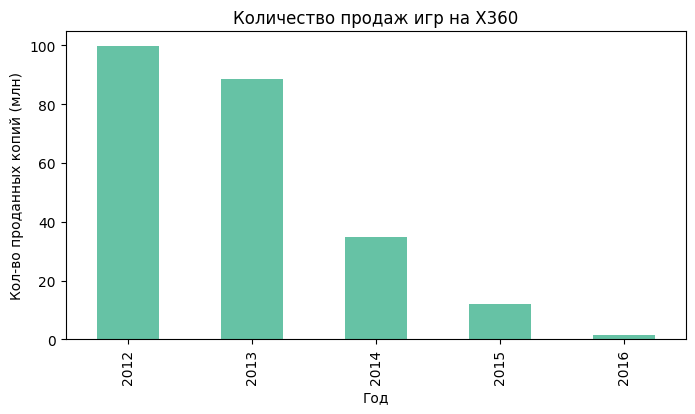

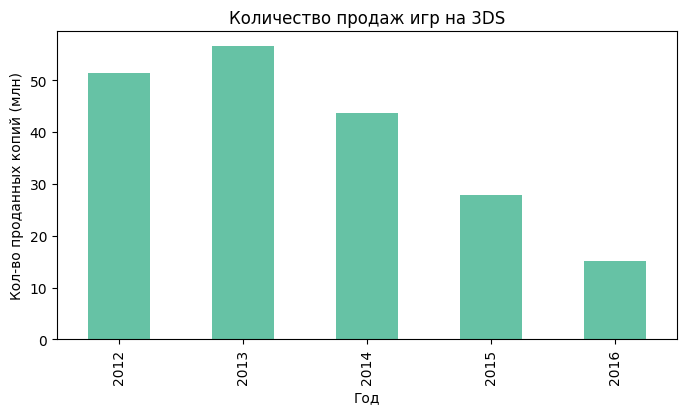

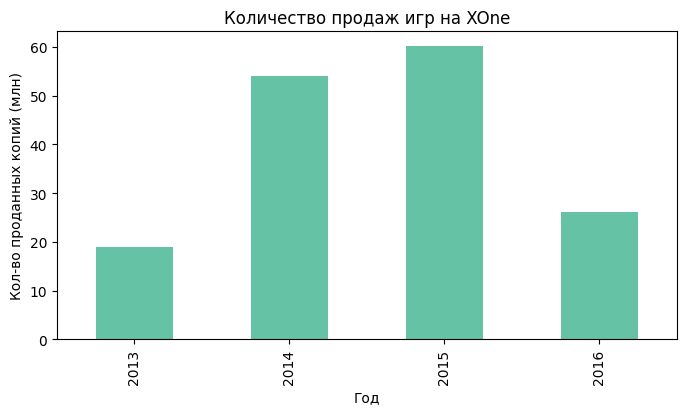

In [31]:
for platform in modern_platforms.reset_index()['platform'].head():
    res = (
        modern_period_df.query('platform == @platform')
        .pivot_table(
            index='year_of_release',
            values='total_sales',
            aggfunc='sum')
        .plot(
            kind='bar',
            figsize=(8, 4),
            xlabel='Год',
            ylabel='Кол-во проданных копий (млн)',
            title = f'Количество продаж игр на {platform}',
            legend=False,
            color=COLOR
        ))

По распределениям видно, что продажи игр на Xbox360, PS3 стремятся к нулю, продажи Nintendo 3DS уже 3 года как прошли свой пик и тоже очень сильно просели, но еще пару лет погут приносить неплохие продажи. Продажи PS4 и XboxOne в 2016 году ниже чем в 2015, однако данные за 2016 год могут быть неполными, но даже если по итогу пик продаж придется на 2015 то крупные продажи на эти платформы могут наблюдаться еще 3-4 года.

In [32]:
top3_platforms_df = modern_period_df.query('platform in ["PS4", "XOne", "3DS"]')
top3_platforms_df.reset_index(drop=True, inplace=True)

Изучим подробнее как продаются игры на разных платформах:

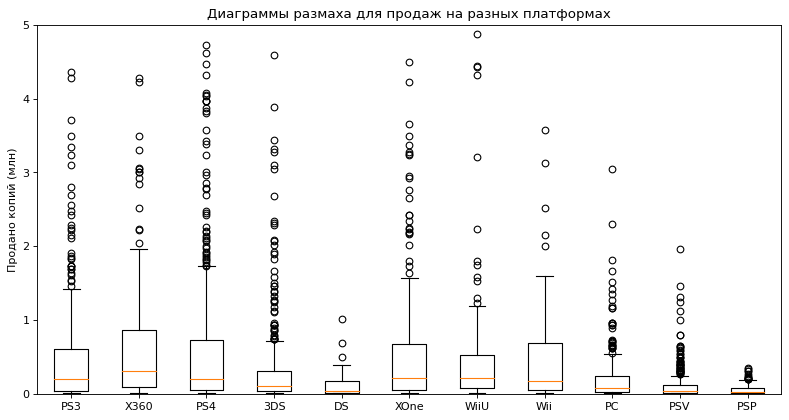

In [39]:
platforms = []
labels = []
for platform in modern_period_df['platform'].unique():
    res = modern_period_df.query('platform == @platform')['total_sales']
    platforms.append(res)
    labels.append(platform)



plt.figure(figsize=(12,6), dpi= 80)
plt.boxplot(platforms, labels=labels)
plt.title('Диаграммы размаха для продаж на разных платформах')
plt.ylabel('Продано копий (млн)')
plt.ylim([0, 5])

plt.show()

In [40]:
for i in range(len(platforms)):
    print(f'------------{labels[i]}------------')
    print(platforms[i].describe())

------------PS3------------
count    492.000000
mean       0.586951
std        1.464113
min        0.010000
25%        0.050000
50%        0.200000
75%        0.610000
max       21.050000
Name: total_sales, dtype: float64
------------X360------------
count    292.000000
mean       0.810068
std        1.712069
min        0.010000
25%        0.100000
50%        0.310000
75%        0.870000
max       16.270000
Name: total_sales, dtype: float64
------------PS4------------
count    392.000000
mean       0.801378
std        1.609456
min        0.010000
25%        0.060000
50%        0.200000
75%        0.730000
max       14.630000
Name: total_sales, dtype: float64
------------3DS------------
count    396.000000
mean       0.491439
std        1.387161
min        0.010000
25%        0.040000
50%        0.110000
75%        0.312500
max       14.600000
Name: total_sales, dtype: float64
------------DS------------
count    31.000000
mean      0.404839
std       1.439245
min       0.010000
25%     

По медианным продажам Xbox360 идет на первом месте, 310 тыс на игру. Несмотря на то, что 3DS значительно превосходит по общему количеству продаж Wii и WiiU вместе взятые, у последних медианные продажи на игру значительно выше 180 и 220 тыс, против 110 у 3DS. Но у 3DS сильно больше выбросов - это говорит о том, что у нее больше "бестселеров", игр которые имеют сверхпродажи. В итоге самые высокие медианные продажи у Xbox360 (310 тыс.), XboxOne (220 тыс.), WiiU (220 тыс.), PS4 (200 тыс.), PS3 (200 тыс.), Wii (180 тыс.). Однако стоит учитывать, что это данные за 5 последних лет, PS3, Xbox360 и Wii - это старые консоли и их продажи в посленее время близки к нулю, а WiiU хоть и новее но имеет плохие общие продажи, хотя те игры что есть продаются хорошо.

### Корреляция между отзывами и продажами на популярных платформах

#### Оценки игроков

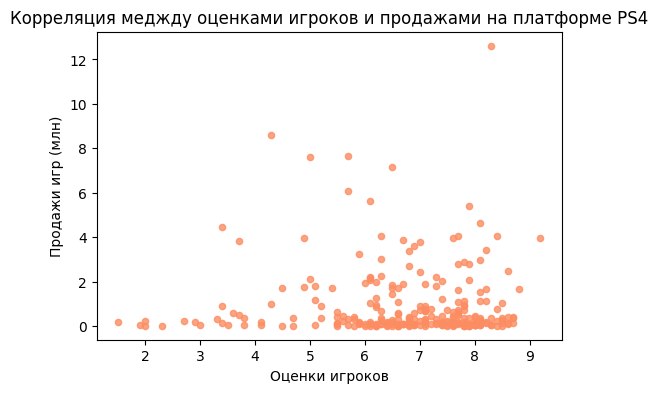

Коэффицент корреляции: -0.031957110204556424


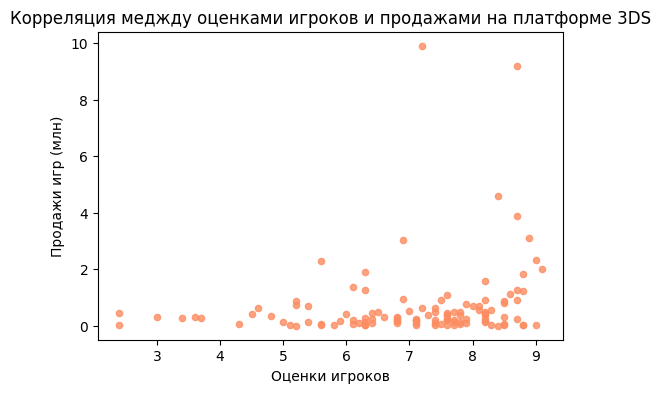

Коэффицент корреляции: 0.19758263411038599


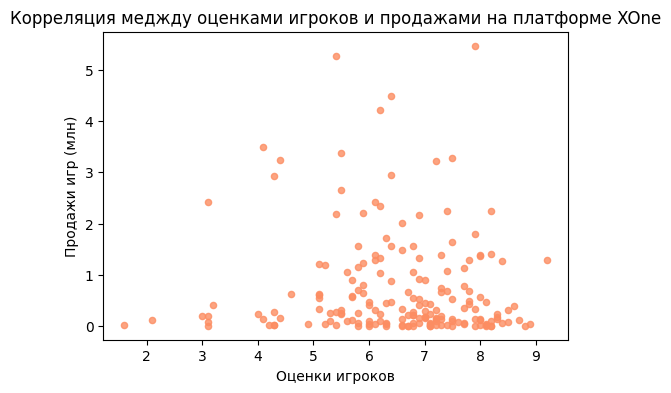

Коэффицент корреляции: -0.06892505328279414


In [47]:
for platform in top3_platforms_df['platform'].unique():
    res = top3_platforms_df.query('platform == @platform')
    res.plot(
        x='user_score',
        y='total_sales',
        kind='scatter',
        alpha=0.8,
        title=f'Корреляция меджду оценками игроков и продажами на платформе {platform}',
        xlabel='Оценки игроков',
        ylabel='Продажи игр (млн)',
        figsize=(6, 4),
        color=COLOR[1])

    plt.show()
    print('Коэффицент корреляции:', res["user_score"].corr(res["total_sales"]))

Судя по коэффицентам корреляций, оценки игроков влияют на продажи на уровне погрешности.

#### Оценки критиков

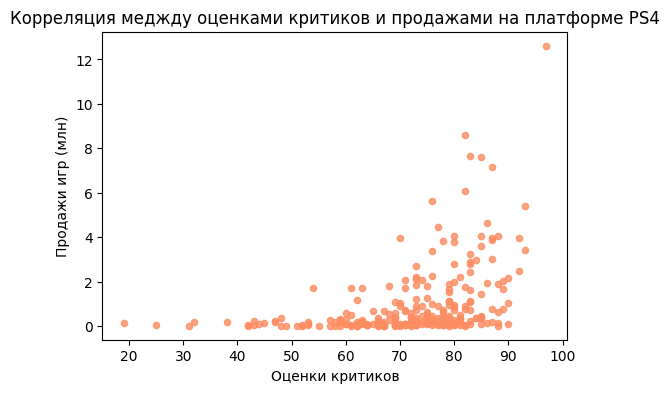

Коэффицент корреляции: 0.40656790206178095


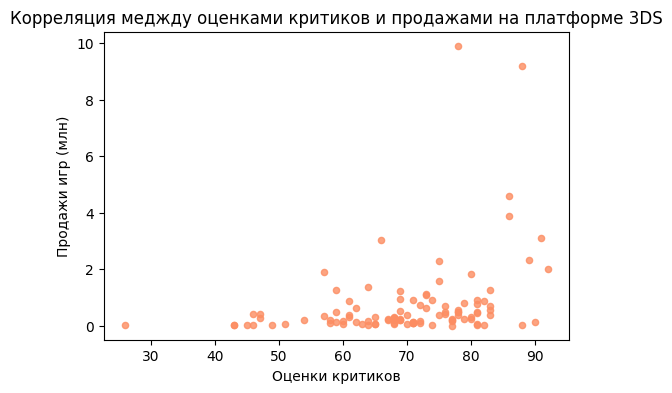

Коэффицент корреляции: 0.3208028695360785


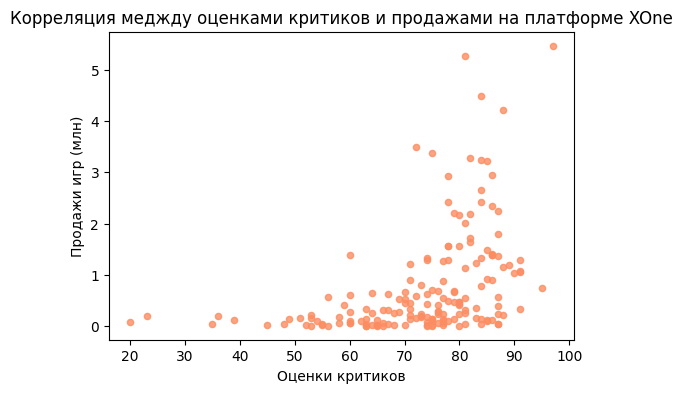

Коэффицент корреляции: 0.4169983280084017


In [49]:
for platform in top3_platforms_df['platform'].unique():
    res = top3_platforms_df.query('platform == @platform')
    res.plot(
        x='critic_score',
        y='total_sales',
        kind='scatter',
        alpha=0.8,
        title=f'Корреляция меджду оценками критиков и продажами на платформе {platform}',
        xlabel='Оценки критиков',
        ylabel='Продажи игр (млн)',
        figsize=(6, 4),
        color=COLOR[1])

    plt.show()
    print('Коэффицент корреляции:', res["critic_score"].corr(res["total_sales"]))


#### Вывод

Влияние оценок критиков куда значительнее чем оценок игроков, больше всего оценки критиков влияют на продажи на PS4 и XboxOne, коэффиценты корреляции у них равны, по 0,41, что может свидетеольствовать о похожей аудитории у этих платформ. У 3DS зависимость продаж от оценок критиков менее значительна, коэффицент корреляции всего 0,32.

### Корреляция между отзывами и продажами на не популярных платформах

In [50]:
not_popular_platforms = modern_period_df.query('platform not in ["PS4", "XOne", "3DS"]')

In [52]:
not_popular_platforms.groupby('platform')[['critic_score', 'user_score']].count()

,critic_score,user_score
platform,,
DS,1,3
PC,198,206
PS3,213,282
PSP,1,4
PSV,107,130
Wii,5,17
WiiU,90,100
X360,171,235


У нескольких платформ очень маленькое число оценок, они рассматриваться не будут.

#### Оценки игроков

In [53]:
for platform in ['PC', 'PS3', 'PSV', 'WiiU', 'X360']:
    res = not_popular_platforms.query('platform == @platform')
    print(f'Коэффицент корреляции платформы {platform}:', res["user_score"].corr(res["total_sales"]))

Коэффицент корреляции платформы PC: -0.12186747630735577
Коэффицент корреляции платформы PS3: -0.006205767686051499
Коэффицент корреляции платформы PSV: -0.004339437514314869
Коэффицент корреляции платформы WiiU: 0.4002190202148617
Коэффицент корреляции платформы X360: 0.006163978646213326


####Оценки критиков

In [54]:
for platform in ['PC', 'PS3', 'PSV', 'WiiU', 'X360']:
    res = not_popular_platforms.query('platform == @platform')
    print(f'Коэффицент корреляции платформы {platform}:', res["critic_score"].corr(res["total_sales"]))

Коэффицент корреляции платформы PC: 0.23724324311567915
Коэффицент корреляции платформы PS3: 0.3341517575509856
Коэффицент корреляции платформы PSV: 0.0944878992931617
Коэффицент корреляции платформы WiiU: 0.34837976012017485
Коэффицент корреляции платформы X360: 0.3605734888507336


#### Вывод

Тут ситуация такая же как и у популярных платформ, оценки критиков куда сильнее влияют на продажи чем оценки игроков. Но на двух платформах ситуация иная, у PSVita продажи вообще не зависят от оценок, а у WiiU наоборот, и оценки игроков и оценки критиков влияют на уровень продаж. Однако выборки слишком маленькие чтобы делать достоверные выводы.

### Распределение игр по жанрам

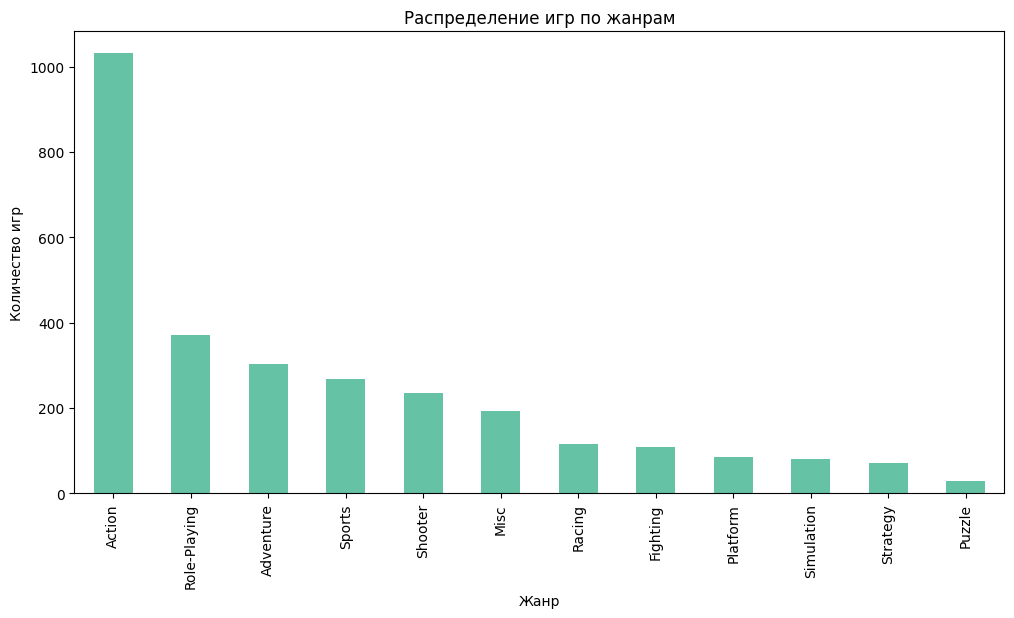

In [56]:
genre_raiting = (
    modern_period_df
    .pivot_table(
        index='genre',
        values='name',
        aggfunc='count')
    .sort_values(
        by='name',
        ascending=False)
    .plot(
        kind='bar',
        figsize=(12, 6),
        title='Распределение игр по жанрам',
        xlabel='Жанр',
        ylabel='Количество игр',
        legend=False,
        color=COLOR
        )
)

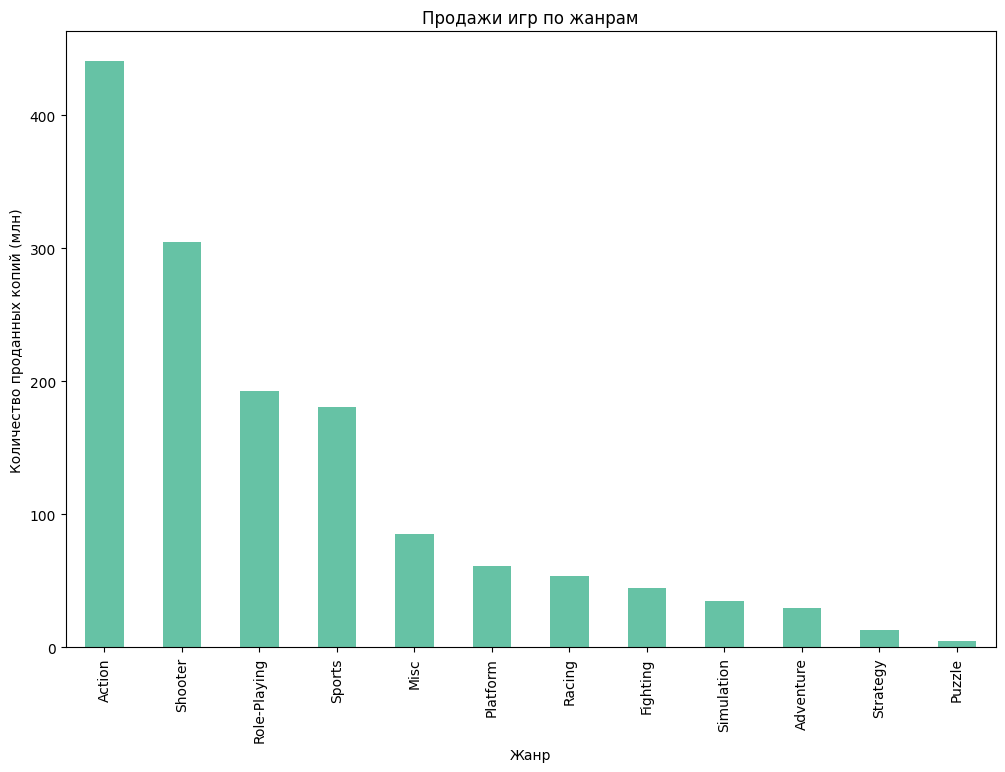

In [57]:
sales_raiting = (
    modern_period_df
    .pivot_table(
        index='genre',
        values='total_sales',
        aggfunc='sum')
    .sort_values(
        by='total_sales',
        ascending=False)
    .plot(
        kind='bar',
        figsize=(12, 8),
        title='Продажи игр по жанрам',
        xlabel='Жанр',
        ylabel='Количество проданных копий (млн)',
        legend=False,
        color=COLOR
        )
)

Самый широкопредставленный жанр - это Action - 1031 игра, он почти в 3 раза превосходит идущий за ним жанр RPG, у него 370 игр. На 3 месте идет жанр Adventure с 302 играми, на 4 месте идет жанр Sports с 267 игрой, а на 5 жанр Shooter с 235 играми.

По продажам на первом месте идет так же Action, с 441 млн проданных копий игр, однако на втором месте с небольшим отставанием идет жанр Shooter с 304 млн проданных копий игр. При разнице в количестве игр более чем в 4 раза, у жанра Action продажи всего лишь на 30% выше чем у игр в жанре Shooter, продажи RPG и игр в жанре Sports тоже выбиваются относительно своей доли на рынке, 192 и 181 млн. проданных копий соответственно. Можно сделать вывод, что несмотря на свою широкую представленность, игры жанра Action продаются не так хорошо, как менее представленные жанры RPG, Sports и Shooter. Жанр Shooter можно считать самым продаваемым.

Жанры с худшими продажами это Adventure, Strategy и Puzzle.

#### Вывод

Жизненный цикл популярных платформ составляет 7-10 лет, с пиком продаж в районе 4-5 лет.

Исследование проводилось за период с 2012 по 2016 год, включительно.

По медианным продажам Xbox360 идет на первом месте, 310 тыс на игру. Несмотря на то, что 3DS значительно превосходит по общему количеству продаж Wii и WiiU вместе взятые, у последних медианные продажи на игру значительно выше 180 и 220 тыс, против 110 у 3DS. Но у 3DS сильно больше выбросов - это говорит о том, что у нее больше "бестселеров", игр которые имеют сверхпродажи. В итоге самые высокие медианные продажи у Xbox360 (310 тыс.), XboxOne (220 тыс.), WiiU (220 тыс.), PS4 (200 тыс.), PS3 (200 тыс.), Wii (180 тыс.). Однако стоит учитывать, что это данные за 5 последних лет, PS3, Xbox360 и Wii - это старые консоли и их продажи в посленее время близки к нулю, а WiiU хоть и новее но имеет плохие общие продажи, хотя те игры что есть продаются хорошо.

Оценки игроков почти не влияют на продажи, в отличии от оценок критиков. Больше всего оценки критиков влияют на продажи на PS4 и XboxOne, коэффиценты корреляции у них равны, по 0,41, что может свидетеольствовать о похожей аудитории у этих платформ. У 3DS зависимость продаж от оценок критиков менее значительна, коэффицент корреляции всего 0,32.

У не популярных платформ ситуация похожая, оценки критиков куда сильнее влияют на продажи чем оценки игроков. Но на двух платформах ситуация иная, у PSVita продажи вообще не зависят от оценок, а у WiiU наоборот, и оценки игроков и оценки критиков влияют на уровень продаж. Однако выборки слишком маленькие чтобы делать достоверные выводы.

Самый широкопредставленный жанр - это Экшен - 385 игр, на втором месте РПГ - 144 игры, на третьем Спорт - 96 играми, а на 4 месте идет жанр Шутер с 81 игрой.

По продажам на первом месте идет Экшн - 178 млн проданных копий игр, на втором Шутер - 149 млн, на 3 и 4 РПГ и Спортивные игры - 118 и 86 млн. проданных копий соответственно. При разнице в количестве игр в 4 раза, У жанра Экшн продажи всего лишь на 17% выше чем у игр в жанре Шутер, при разнице в количестве игр в 4 раза.

Игры жанра Экшн продаются не так хорошо, как менее представленные жанры РПГ, Спорт и Шутер. Жанр Шутер можно считать самым продаваемым, а жанры с худшими продажами - это Приключения, Стратегии и Пазлы (13, 2,6 и 2,3 млн копий соответственно).

## Шаг 4. Портрет пользователя каждого региона

### Самые популярные платформы

Выведем таблицы с ТОП-5 платформ в каждом регионе по количеству проданных копий игр за поседние 5 лет:

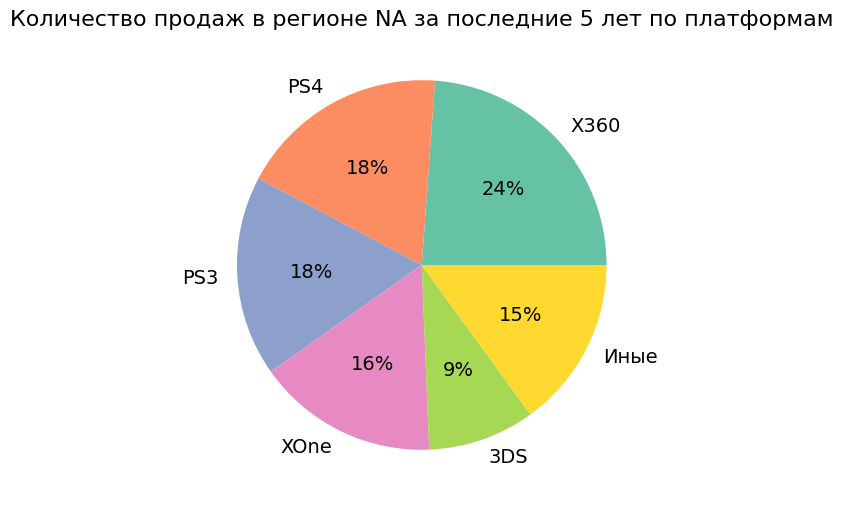

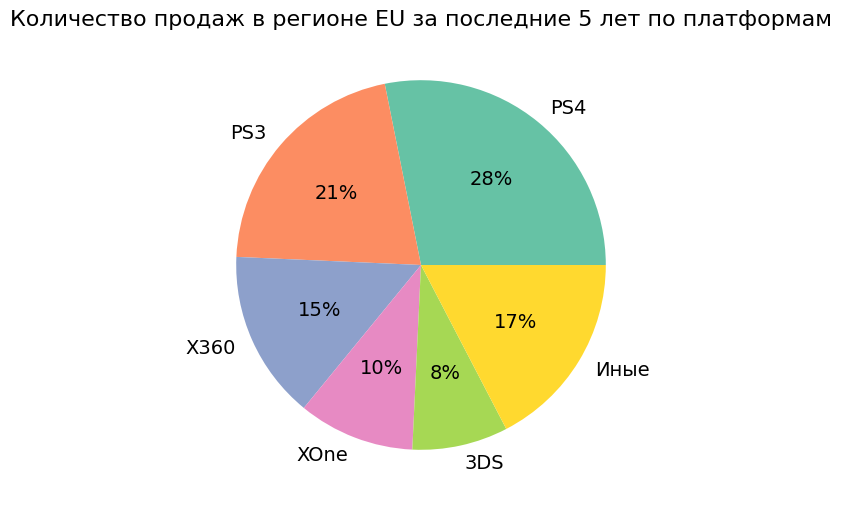

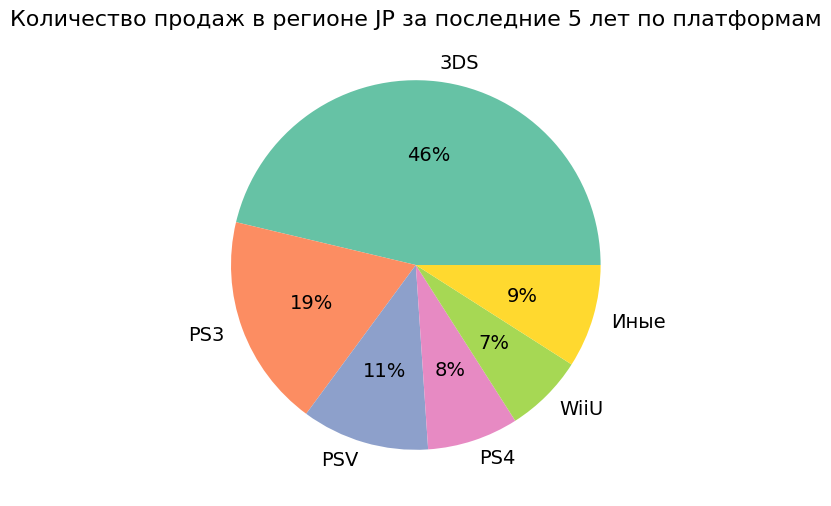

In [59]:
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    res = (
        modern_period_df
        .pivot_table(
            index='platform',
            values=region,
            aggfunc='sum')
        .sort_values(
            by=region,
            ascending=False
        )
    )
    res = res.reset_index()
    res.columns = ['platform', 'sales']
    team = []
    points = []
    etc = 0

    for i in range(len(res)):
        if i < 5:
            team.append(res.iloc[i]['platform'])
            points.append(int(res.iloc[i]['sales']))
        else:
            etc += int(res.iloc[i]['sales'])

    team.append('Иные')
    points.append(etc)

    plt.figure(figsize=(6, 6))
    plt.title(
        f'Количество продаж в регионе {region[:2].upper()} за последние 5 лет по платформам',
        fontdict={"fontsize":16}
    )
    plt.pie(
        x=points,
        labels=team,
        autopct='%1.0f%%',
        textprops={'fontsize':14},
        colors=sns.color_palette('Set2')
    )
    plt.show()

На графиках видно:
- В Северной Америке самая популярная платформа это Xbox360 (24%), на 2 и 3 с одинаковыми продажами идут PS4 (18%) и PS3 (18%) и только потом идет XboxOne (16%). 3DS (9%) на 5 месте.
- В Европе на первых двух местах идут PS4 (28%) и PS3 (21%), и только потом Xbox360 (15%) и XboxOne (10%), 3DS (8%) как и в Северной Америке идет на последнем месте.
- В Японии ситуация координально иная, в топ-5 попали только японские консоли, с огромным отрывом, в 2,5 раза, на первом месте идет Nintendo 3DS (46%), на втором PS3 (19%), затем с одинаковыми отрывами друг от друга идут PSVita (11%), PS4 (8%) и WiiU (7%).

Из всего выше можно сделать вывод, что в Северной Америке предпочтение в первую очередь отдается американской платформе - XBOX и только потом японским PlayStation, в Европе наоборот в 2 раза больше людей отдают предпочтение PlayStation. В Японии игроки предпочитают играть только на японских приставках, при этом - это единственный регион где на первом месте находиться портативная консоль, еще и с огромным отрывом. Так же единственный регион где в топ-5 вошли 2 портативные консоли (PSVita - 3 место).

На графиках так же видно, что за последние 5 лет, в сумме, на старые платформы было проданно игр больше чем на новые, однако из Шага 3 видно, что тенденция меняется в пользу новых консолей.

### Самые популярные жанры

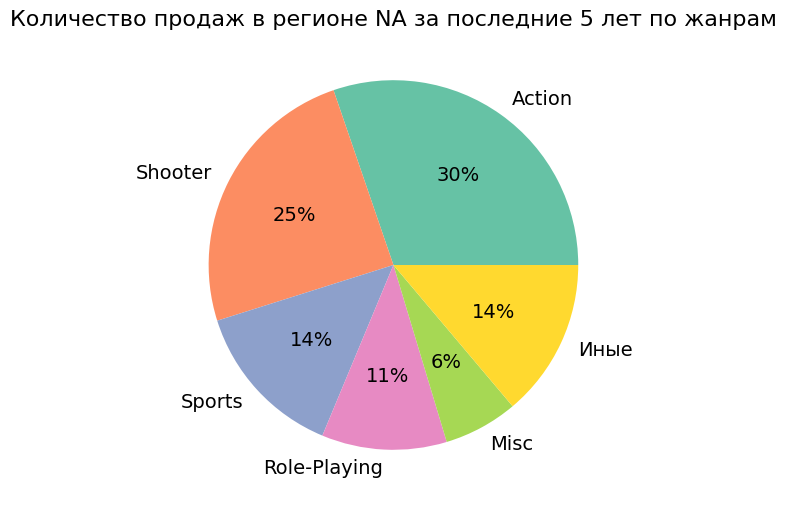

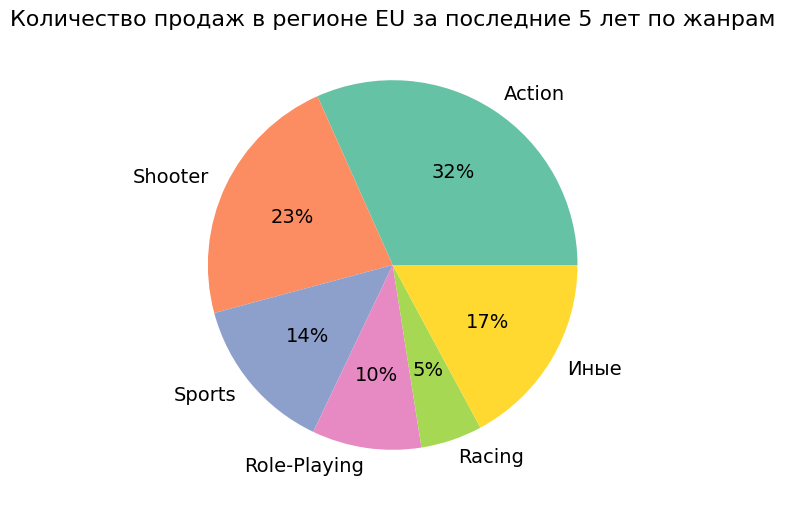

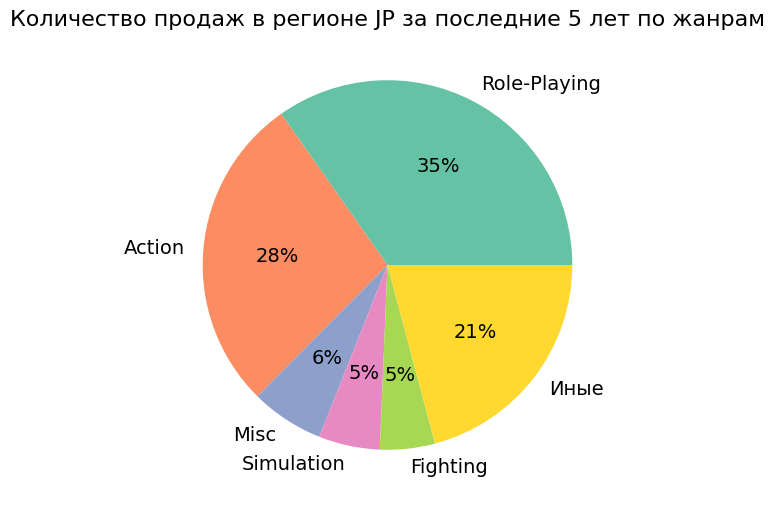

In [60]:
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    res = (
        modern_period_df
        .pivot_table(
            index='genre',
            values=region,
            aggfunc='sum')
        .sort_values(
            by=region,
            ascending=False
        )
    )
    res = res.reset_index()
    res.columns = ['platform', 'sales']
    team = []
    points = []
    etc = 0

    for i in range(len(res)):
        if i < 5:
            team.append(res.iloc[i]['platform'])
            points.append(int(res.iloc[i]['sales']))
        else:
            etc += int(res.iloc[i]['sales'])

    team.append('Иные')
    points.append(etc)

    plt.figure(figsize=(6, 6))
    plt.title(
        f'Количество продаж в регионе {region[:2].upper()} за последние 5 лет по жанрам',
        fontdict={"fontsize":16}
    )
    plt.pie(
        x=points,
        labels=team,
        autopct='%1.0f%%',
        textprops={'fontsize':14},
        colors=sns.color_palette('Set2')
    )
    plt.show()

На графиках видно:
- В Северной Америке и в Европе предпочтения игроков почти идентичны, В Северной Америке игроки предпочитают Action (30%), Shooter (25%), Sports (14%) и RPG (11%), Misc (6%). Европе Racing.
- В Европе игроки играют а основном  Action (32%), Shooter (23%), Sports (14%) и RPG (10%), Racing (5%).
- В Японии предпочтения сильно отличаются с огромным отрывом люди отдают предпочтения жанру RPG (35%) и Action (28%), дальше почти в равной степени игроки предпочитают жанры Misc (6%), Simulation (5%), Fighting (5%).

Япония опять сильно отличается от Северной Америки и Европы, тут игроки куда сильнее любят РПГ и не любят шутеры со спортивными играми. Позиции экшн игр везде сильны.

### Влияние возрастного рейтинга на продажи

*Описание ретинга ESRB:*
- **E** — Для всех;
- **E10+** — Для всех от 10 лет и старше;
- **T** — Для подростков;
- **M** — Для взрослых.

Для тех игр для которых информация о рейтинге отсутствовала указано **not defined**

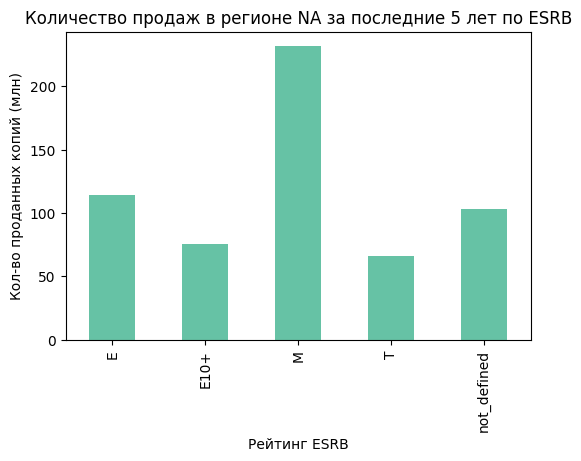

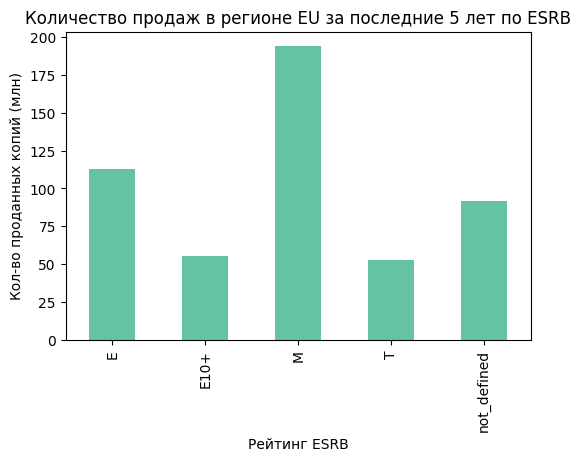

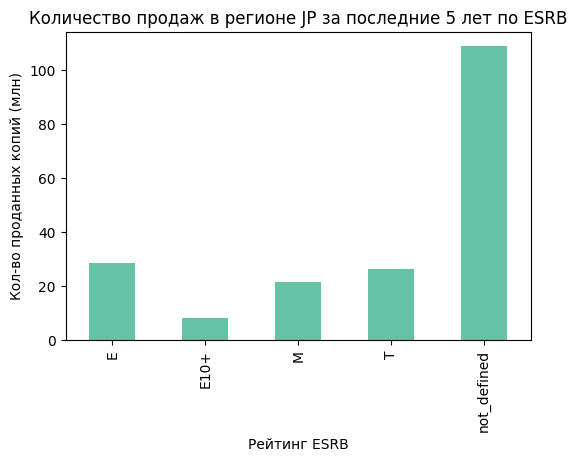

In [62]:
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    res = (
        modern_period_df
        .pivot_table(
            index='rating',
            values=region,
            aggfunc='sum')
    )
    res.plot(
        kind='bar',
        figsize=(6, 4),
        xlabel='Рейтинг ESRB',
        ylabel='Кол-во проданных копий (млн)',
        title = f'Количество продаж в регионе {region[:2].upper()} за последние 5 лет по ESRB',
        legend=False,
        color=COLOR
    )

In [64]:
modern_period_df.query('rating == "not_defined"').groupby(by='platform')['name'].count()

,name
platform,
3DS,254
DS,16
PC,65
PS3,193
PS4,137
PSP,166
PSV,273
Wii,20
WiiU,42


На графиках видно:
- В Северной Америке и в Европе возрастной рейтинг оказывает одинаковое влияние на продажи. Самой высокой популярностью, с большим отрывом пользуются игры для взрослых, затем идут игры для всех и самые плохопродоваемые игры 10+ и игры для подростков.
- У Японии есть интересная особенность, там половина игр не имеет рейтинга, подавляющее большенство таких игр приходится на японские платформы, возможно это ошибка при сборе данных продаж в регионе, может это как-то связано с особенностями определения возрастнго рейтинга в Японии, например иная система оценки вместо ESRB. В остальном в Японии на первых местах с небольшой разницей идут игры для всех и для подростков, игры для взрослых идут на 4 месте, а в категории 10+, как и в Северной Америке и Европе одни из самых низких продаж.


### Вывод

На основании данных взятых за поседние 5 лет можно сделать следующие выводы:

- В Северной Америке предпочтение в первую очередь отдается американской платформе - XBOX и только потом японским PlayStation, в Европе наоборот в 2 раза больше людей отдают предпочтение PlayStation. В Японии игроки предпочитают играть только на японских приставках, при этом - это единственный регион где на первом месте находиться портативная консоль, еще и с огромным отрывом. Так же единственный регион где в топ-5 вошли 2 портативные консоли (PSVita - 3 место).
- В Северной Америке и в Европе предпочтения игроков в жанрах почти идентичны, там и там люди предпочитают Action, Shooter, Sports и RPG. В Японии предпочтения сильно отличаются с огромным отрывом люди отдают предпочтения жанру RPG и Action, дальше почти в равной степени игроки предпочитают жанры Misc, Simulation, Fighting. Япония сильно отличается от Северной Америки и Европы, тут игроки куда сильнее любят РПГ и не любят шутеры со спортивными играми. Позиции экшн игр везде сильны.
- В Северной Америке и в Европе возрастной рейтинг оказывает одинаковое влияние на продажи. Самой высокой популярностью, с большим отрывом пользуются игры для взрослых, затем идут игры для всех и самые плохопродоваемые игры 10+ и игры для подростков. В Японии всё иначе, тут на первых местах с небольшой разницей идут игры для всех и для подростков, игры для взрослых идут на 3 месте, а в категории 10+, как и в Северной Америке и Европе одни из самых низких продаж.

## Шаг 5. Пороверка гипотез

### Гипотеза №1

*Одинаковые ли пользовательские рейтинги платформ Xbox One и PC?*

Для сравнения двух разных независисых выборок нужно провести двухвыборочный t-тест. Гипотеза является дусторонней так как не важно в большую или меньшую сторону отличаются средние.

H0 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.</br>
H1 - Средние пользовательские рейтинги платформ Xbox One и PC разные.

In [65]:
xone_score = modern_period_df.query('platform == "XOne"')['user_score'].dropna()
pc_score = modern_period_df.query('platform == "PC"')['user_score'].dropna()


print(f'Среднй пользовательский рейтинг у XboxOne: {np.mean(xone_score)}')
print(f'Среднй пользовательский рейтинг у PC: {np.mean(pc_score)}')


alpha = 0.05

results = st.ttest_ind(
    xone_score,
    pc_score
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднй пользовательский рейтинг у XboxOne: 6.521428571428572
Среднй пользовательский рейтинг у PC: 6.4286407766990274
p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


С большой долей вероятности средние пользовательские рейтинги платформ Xbox One и PC не имеют статистически значимых отличий.

##### Гипотеза №2

*Разные ли пользовательские рейтинги у жанров Action и Sports?*

H0 - Средние пользовательские рейтинги жанров Action и Sports одинаковые.</br>
H1 - Средние пользовательские рейтинги жанров Action и Sports разные.

In [66]:
action_score = modern_period_df.query('genre == "Action"')['user_score'].dropna()
sport_score = modern_period_df.query('genre == "Sports"')['user_score'].dropna()


print(f'Среднй пользовательский рейтинг у жанра Action: {np.mean(action_score)}')
print(f'Среднй пользовательский рейтинг у жанра Sport: {np.mean(sport_score)}')


alpha = 0.05

results = st.ttest_ind(
    action_score,
    sport_score
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднй пользовательский рейтинг у жанра Action: 6.825047801147227
Среднй пользовательский рейтинг у жанра Sport: 5.455670103092784
p-значение: 4.804523380462917e-26
Отвергем нулевую гипотезу


Гипотеза Н0 отвергнута, значит наиболее вероятно, что средние пользовательские рейтинги жанров Action и Sports разные.

## Шаг 6. Общие выводы

Были получены и проанализированы данные по продажам игрового интернет магазина.


**Полученные данные были обработаны:**
- Названия столбцов датафрейма приведены к snake_case;
- Столбец "user_score" преобразован в тип данных float, для этого значения "tbd" заменины на NaN;
- Пропуски в столбце "year_of_release", составляющие 1,5% от общей выборки были удалены, так как в данном исследовании они не важны;
- Пропуски в столбце "rating" заполнены значениями "not defined";
- Обнаружены и удалены два неявных дубликата.

**Исследование проводилось на основе данных за период с 2012 по 2016 год, включительно. В ходе исслдования было выяснено:**


- Жизненный цикл популярных платформ составляет 7-10 лет, с пиком продаж в районе 4-5 лет.
- Самые высокие медианные продажи у Xbox360 (310 тыс.), XboxOne (220 тыс.), WiiU (220 тыс.), PS4 (200 тыс.), PS3 (200 тыс.), Wii (180 тыс.). Однако стоит учитывать, что это данные за 5 последних лет, PS3, Xbox360 и Wii - это старые консоли и их продажи в посленее время близки к нулю, а WiiU хоть и новее но имеет плохие общие продажи, хотя те игры что есть продаются хорошо.
- Оценки игроков почти не влияют на продажи, в отличии от оценок критиков. Больше всего оценки критиков влияют на продажи на PS4 и XboxOne. У 3DS зависимость продаж от оценок критиков менее значительна. У менее популярных платформ ситуация похожая, оценки критиков куда сильнее влияют на продажи чем оценки игроков.


**Самый широкопредставленный жанры:**
- Action - 1031 игра;
- RPG - 370 игры;
- Adventure - 302 игры;
- Sports - 267 игр;
- Shooter - 235 игр.

**Самые продаваемые жанры:**
- Action - 441 млн. копий;
- Shooter - 304 млн. копий;
- RPG - 192 млн. копий;
- Sports - 181 млн. копий.

Жанр Экшн берет своим количеством, однако при пересчете количества проданных игр на их общее количество получается следующий рейтинг:
- Shooter - 1,3 млн продаж на игру
- Sports - 0,7 млн продаж на игру
- RPG - 0,5 млн продаж на игру
- Action - 0,4 млн продаж на игру

Хуже всего продаются Adventure, Strategy и Puzzle.

На основании данных взятых за поседние 5 лет можно сделать следующие выводы о портрете пользователя каждого из регионов:

**Пользователь из Северной Америки:**
- Предпочитает Xbox или PlayStation;
- Редко играет на портативных консолях;
- В основном играет игры в жанре Action, Shooter, Sports, немного реже RPG и Misc;
- Играет в основном игры со взрослым возрастным рейтингом.

**Пользователь из Европы:**
- Предпочитает PlayStation, реже Xbox;
- Редко играет на портативных консолях;
- В основном играет игры в жанре Action, Shooter, Sports, немного реже RPG и Racing;
- Играет в основном игры со взрослым возрастным рейтингом.

**Пользователь из Японии:**
- Предпочитает Nintendo, реже PlayStation, за очень редким исключением Xbox;
- Чаще всего играет на портативных консолях;
- В основном играет игры в жанре RPG и Action, значительно реже Misc, Simulation, Fighting;
- Играет игры в для всех, для подростков иногда со взрослым рейтингом

В ходе проверки гипотез выявлено, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, а средние пользовательские рейтинги жанров Action и Sports разные.



**Итог:**

Стоит делать акцент на шутеры, у них самые высокие продажи на одну игру, и на экшн-игры, продажи на игру там значительно меньше но их много и они популярны на всех основных рынках. Рынки Северной Америки и Европы почти идентичны по своим предпочтениям, видна похожесть менталитетов. Там стоит отдать предпочтения консолям PlayStation и Xbox и играм для взрослых. Рынок Японии не имеет ничего общего с остальными двумя, там люди играют в портативные консоли, любят Nintendo, совсем не играют в Xbox. В Японии акцент стоит делать на РПГ, а так же игры для всех возрастов, там хорошо играют и игры для взрослых и для детей с подросками, в отлчии от Северной Америки и Европы. Так же на всех рынках, игроки склонны обращать больше внимание на оценки критиков, нежели на оценки пользователей. Так же стоит установить природу пропусков в возрастном рейтинге ESRB, особенно в Японии.